In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")
df = pd.read_csv(f'{path}/btcusd_1-min_data.csv')

In [ ]:
df

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
7098923,1.751417e+09,105647.00,105647.00,105623.00,105623.00,0.068872
7098924,1.751417e+09,105621.00,105621.00,105618.00,105618.00,0.054222
7098925,1.751417e+09,105584.00,105584.00,105539.00,105539.00,0.080127
7098926,1.751417e+09,105539.00,105539.00,105484.00,105484.00,0.071111


In [ ]:
df['datetime'] = pd.to_datetime(df['Timestamp'], unit='s')
df.drop(columns=['Timestamp', 'High', 'Low', 'Open'], inplace=True)
df.rename(columns={'Close': 'Price'}, inplace=True)

# Сортировка по дате перед группировкой и разделением
df.sort_values(by='datetime', inplace=True)

# Агрегация данных по дням (1440 минут)
df = df.groupby(pd.Grouper(key='datetime', freq='1440T')).mean().reset_index()

# Удаление строк с NaN, которые могут появиться после агрегации
df.dropna(inplace=True)

/tmp/ipython-input-3-3928851387.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.groupby(pd.Grouper(key='datetime', freq='1440T')).mean().reset_index()


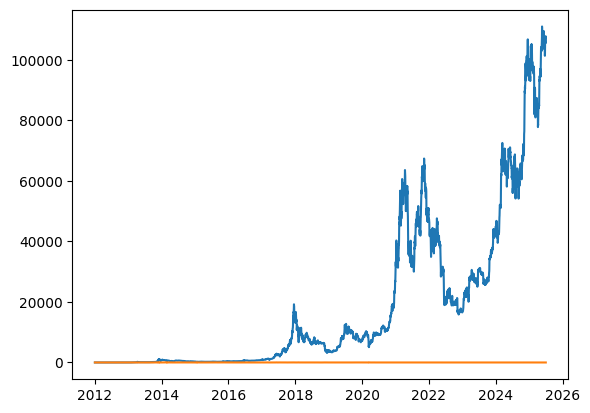

In [ ]:
plt.plot(df['datetime'], df['Price'])
plt.plot(df['datetime'], df['Volume'])

In [ ]:
# Разделение данных по дате
train = df[df['datetime'] < "2025-01-01"].copy() # .copy() чтобы избежать SettingWithCopyWarning
test = df[df['datetime'] >= "2025-01-01"].copy()

print(f"Размер обучающего набора: {len(train)}")
print(f"Размер тестового набора: {len(test)}")

Размер обучающего набора: 4749
Размер тестового набора: 183


In [ ]:
# Функция reshape
def reshape(df, columns):
  result = []
  for column in columns:
    result.append(df[column].values.reshape(-1, 1))

  return np.hstack(result)

In [ ]:
# Выбранные признаки
FEATURES = ['Price', 'Volume']

In [ ]:
# Масштабирование данных (от 0 до 1)
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(reshape(train, FEATURES))
test_scaled = scaler.transform(reshape(test, FEATURES))

In [ ]:
# Функция для создания последовательностей (X, y)
def create_sequences(data, time_steps=90, target_feature_index=0):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, :])  # X: прошлые `time_steps` значений для всех features
        y.append(data[i, target_feature_index]) # y: следующее значение ДЛЯ PRICE (индекс 0), а не Volume (индекс 1)
    return np.array(X), np.array(y)

In [ ]:
# Параметры последовательности
TIME_STEPS = 90  # Сколько прошлых дней использовать для предсказания

In [ ]:
# Создание обучающих и тестовых данных (Target - Price)
X_train_price, y_train_price = create_sequences(train_scaled, TIME_STEPS, 0)
X_test_price, y_test_price = create_sequences(test_scaled, TIME_STEPS, 0)

In [ ]:
# Создание обучающих и тестовых данных (Target - Volume)
X_train_volume, y_train_volume = create_sequences(train_scaled, TIME_STEPS, 1)
X_test_volume, y_test_volume = create_sequences(test_scaled, TIME_STEPS, 1)

In [ ]:
# Проверка размеров
print("X_train_price:", X_train_price.shape, "X_train_volume:", X_train_volume.shape)  # (N_train, TIME_STEPS, NUMBER_OF_FEATURES)
print("y_train_price:", y_train_price.shape, "y_train_volume:", y_train_volume.shape)  # (N_train,)
print("X_test_price:", X_test_price.shape, "X_test_volume:", X_test_volume.shape)    # (N_test, TIME_STEPS, NUMBER_OF_FEATURES)
print("y_test_price:", y_test_price.shape, "y_test_volume:", y_test_volume.shape)    # (N_test,)

X_train_price: (4659, 90, 2) X_train_volume: (4659, 90, 2)
y_train_price: (4659,) y_train_volume: (4659,)
X_test_price: (93, 90, 2) X_test_volume: (93, 90, 2)
y_test_price: (93,) y_test_volume: (93,)


# Best parametrs

- lstm 65
- dropout .25
- lstm 62
- dropout .25
- lstm 60
- dropout .25
- dense 1

time steps 90

In [ ]:
# Построение модели LSTM
model_volume = Sequential([
    LSTM(65, return_sequences=True, input_shape=(TIME_STEPS, len(FEATURES))),
    Dropout(0.25),
    LSTM(62, return_sequences=True),
    Dropout(0.25),
    LSTM(60),
    Dropout(0.25),
    Dense(1)
])

model_volume.compile(optimizer='adam', loss='mse')
model_volume.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 65)         │        17,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 65)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 90, 62)         │        31,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60)             │        29,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,005 (308.61 KB)

 Trainable params: 79,005 (308.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_price = Sequential([
    LSTM(65, return_sequences=True, input_shape=(TIME_STEPS, len(FEATURES))),
    Dropout(0.25),
    LSTM(62, return_sequences=True),
    Dropout(0.25),
    LSTM(60),
    Dropout(0.25),
    Dense(1)
])

model_price.compile(optimizer='adam', loss='mse')
model_price.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 90, 65)         │        17,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90, 65)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 90, 62)         │        31,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60)             │        29,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,005 (308.61 KB)

 Trainable params: 79,005 (308.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class EarlyStopLossCallback(Callback):
    def __init__(self, threshold):
        super().__init__()
        self.prev = []
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_loss = logs.get('loss')
        if current_loss is not None:
            if current_loss < self.threshold:
                print(f"\nДостигнут порог потерь {self.threshold}, остановка обучения.")
                self.model.stop_training = True

            if len(self.prev) == 2:
                print(self.prev, current_loss)

                if (current_loss > 1.1 * self.prev[-1]) and (self.prev[-1] > 1.1 * self.prev[-2]):
                    self.model.stop_training = True

            self.prev.append(current_loss)
            if len(self.prev) > 2:
                self.prev.pop(0)

In [ ]:
# Обучение модели
model_price.fit(X_train_price, y_train_price, epochs=25, batch_size=32, callbacks=[EarlyStopLossCallback(threshold=3e-05)])

Epoch 1/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.9829e-04
Epoch 2/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.1947e-04
Epoch 3/25
144/146 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8767e-04[0.0004314414691179991, 0.000518229731824249] 0.0004195999354124069
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.8833e-04
Epoch 4/25
144/146 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.0746e-04[0.000518229731824249, 0.0004195999354124069] 0.00037188405985943973
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.0673e-04
Epoch 5/25
142/146 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7398e-04[0.0004195999354124069, 0.00037188405985943973] 0.0004601692489814013
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 4.7340e-04
Epoch 6/25
143/146 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0229e-04[0.00037188405985943973, 0.0004601692489814013] 0.0004715016402769834
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.0145e-04
Epoch 7/25
142/146 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

In [ ]:
# Обучение модели
model_volume.fit(X_train_volume, y_train_volume, epochs=25, batch_size=32, callbacks=[EarlyStopLossCallback(threshold=3e-05)])

Epoch 1/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0048
Epoch 2/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0032
Epoch 3/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033[0.0036953899543732405, 0.0032301649916917086] 0.0031909083481878042
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0033
Epoch 4/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033[0.0032301649916917086, 0.0031909083481878042] 0.0031435522250831127
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0033
Epoch 5/25
144/146 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031[0.0031909083481878042, 0.0031435522250831127] 0.00304920575581491
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0031
Epoch 6/25
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029[0.0031435522250831127, 0.00304920575581491] 0.0029468003194779158
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0029
Epoch 7/25
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031[0.00304920575581491, 0.00294

In [ ]:
def predict_future_multistep(model_price, model_volume, initial_data_scaled, scaler, n_steps_ahead):
    """
    Выполняет итеративное многошаговое прогнозирование Price и Volume.

    Args:
        model_price (keras.Model): Обученная модель LSTM для прогнозирования Price.
        model_volume (keras.Model): Обученная модель LSTM для прогнозирования Volume.
        initial_data_scaled (np.array): Последние TIME_STEPS масштабированных данных
                                        (Price, Volume) для начала прогноза.
                                        Должен быть shape (1, TIME_STEPS, len(FEATURES)).
        scaler (MinMaxScaler): Обученный MinMaxScaler для обратного преобразования.
        n_steps_ahead (int): Количество шагов (дней) для прогнозирования в будущее.

    Returns:
        tuple: (future_predicted_prices, future_predicted_volumes) в исходном масштабе.
    """
    current_input_sequence = initial_data_scaled.copy()
    future_predicted_prices_scaled = []
    future_predicted_volumes_scaled = []

    for _ in range(n_steps_ahead):
        # Предсказываем следующий Price и Volume
        predicted_price_scaled = model_price.predict(current_input_sequence, verbose=0)[0][0] # verbose=0 чтобы не выводить прогресс
        predicted_volume_scaled = model_volume.predict(current_input_sequence, verbose=0)[0][0]

        future_predicted_prices_scaled.append(predicted_price_scaled)
        future_predicted_volumes_scaled.append(predicted_volume_scaled)

        # Формируем новый входной вектор для следующего шага
        # Это новый предсказанный (Price, Volume)
        new_feature_vector = np.array([[predicted_price_scaled, predicted_volume_scaled]]) # Shape (1, len(FEATURES))

        # Обновляем последовательность: убираем старый первый элемент, добавляем новый предсказанный
        current_input_sequence = np.append(current_input_sequence[:, 1:, :], new_feature_vector.reshape(1, 1, len(FEATURES)), axis=1)

    # Обратное преобразование предсказанных значений
    # Для обратного преобразования нам нужно объединить price и volume в один массив
    combined_scaled_predictions = np.array(list(zip(future_predicted_prices_scaled, future_predicted_volumes_scaled)))

    # Создаем фиктивные столбцы для обратного преобразования, так как scaler был обучен на двух признаках.
    # Фактически, мы уже собрали их в combined_scaled_predictions, где Price - 0-й столбец, Volume - 1-й.
    # Остается только вызвать inverse_transform.
    inverted_predictions = scaler.inverse_transform(combined_scaled_predictions)

    # Извлекаем Price и Volume из обратно преобразованных данных
    future_predicted_prices = inverted_predictions[:, 0]
    future_predicted_volumes = inverted_predictions[:, 1]

    return future_predicted_prices, future_predicted_volumes

In [ ]:
# Подготовка к многошаговому прогнозу
# Берем последние TIME_STEPS данные из тестового набора для начала прогноза
initial_sequence_for_prediction = test_scaled[-TIME_STEPS:].reshape(1, TIME_STEPS, len(FEATURES))
N_STEPS_AHEAD = 7 # Прогнозируем на N дней вперед

print(f"\n--- Выполнение многошагового прогноза на {N_STEPS_AHEAD} дней вперед ---")
future_prices, future_volumes = predict_future_multistep(
    model_price=model_price,
    model_volume=model_volume,
    initial_data_scaled=initial_sequence_for_prediction,
    scaler=scaler,
    n_steps_ahead=N_STEPS_AHEAD
)


--- Выполнение многошагового прогноза на 7 дней вперед ---


In [ ]:
# --- Метрики для PRICE ---
predicted_scaled_price = model_price.predict(X_test_price, verbose=0)
dummy_volume_for_price_prediction = np.zeros_like(predicted_scaled_price)
predicted_price_combined_for_inverse = np.concatenate([predicted_scaled_price, dummy_volume_for_price_prediction], axis=1)
predicted_price = scaler.inverse_transform(predicted_price_combined_for_inverse)[:, 0]

y_test_price_reshaped_for_inverse = y_test_price.reshape(-1, 1)
dummy_volume_for_y_test_price = np.zeros_like(y_test_price_reshaped_for_inverse)
y_test_price_combined_for_inverse = np.concatenate([y_test_price_reshaped_for_inverse, dummy_volume_for_y_test_price], axis=1)
y_test_price_original = scaler.inverse_transform(y_test_price_combined_for_inverse)[:, 0]

print("\n--- Метрики для Price на тестовом наборе ---")
mse_price_original = mean_squared_error(y_test_price_original, predicted_price)
print(f"MSE (Price в исходном масштабе): {mse_price_original:.4f}")
rmse_price_original = np.sqrt(mse_price_original)
print(f"RMSE (Price в исходном масштабе): {rmse_price_original:.4f}")
mape_price = mean_absolute_percentage_error(y_test_price_original, predicted_price) * 100
print(f"MAPE (Price): {mape_price:.2f}%")

# Расчет Directional Accuracy для Price
print("\n--- Расчет Directional Accuracy для Price ---")
actual_prices_for_da = test['Price'].iloc[TIME_STEPS:].values # Соответствует y_test_price_original
previous_day_prices_for_da = test['Price'].iloc[TIME_STEPS-1:-1].values # Цены за день до actual_prices_for_da

correct_direction_predictions_price = 0
total_predictions_with_change_price = 0

for i in range(len(actual_prices_for_da)):
    # Используем actual_prices_for_da[i] вместо y_test_price_original[i] для ясности,
    # так как они должны быть эквивалентны.
    actual_change = np.sign(actual_prices_for_da[i] - previous_day_prices_for_da[i])
    predicted_change = np.sign(predicted_price[i] - previous_day_prices_for_da[i])

    if actual_change != 0: # Считаем только те случаи, где было фактическое изменение
        total_predictions_with_change_price += 1
        if actual_change == predicted_change:
            correct_direction_predictions_price += 1

directional_accuracy_price = (correct_direction_predictions_price / total_predictions_with_change_price) * 100 if total_predictions_with_change_price > 0 else 0
print(f"Количество предсказаний с изменением: {total_predictions_with_change_price}")
print(f"Количество правильно угаданных направлений: {correct_direction_predictions_price}")
print(f"Directional Accuracy (DA): {directional_accuracy_price:.2f}%")


# --- Метрики для VOLUME ---
predicted_scaled_volume = model_volume.predict(X_test_volume, verbose=0)
dummy_price_for_volume_prediction = np.zeros_like(predicted_scaled_volume)
predicted_volume_combined_for_inverse = np.concatenate([dummy_price_for_volume_prediction, predicted_scaled_volume], axis=1)
predicted_volume = scaler.inverse_transform(predicted_volume_combined_for_inverse)[:, 1]

y_test_volume_reshaped_for_inverse = y_test_volume.reshape(-1, 1)
dummy_price_for_y_test_volume = np.zeros_like(y_test_volume_reshaped_for_inverse)
y_test_volume_combined_for_inverse = np.concatenate([dummy_price_for_y_test_volume, y_test_volume_reshaped_for_inverse], axis=1)
y_test_volume_original = scaler.inverse_transform(y_test_volume_combined_for_inverse)[:, 1]

print("\n--- Метрики для Volume на тестовом наборе ---")
mse_volume_original = mean_squared_error(y_test_volume_original, predicted_volume)
print(f"MSE (Volume в исходном масштабе): {mse_volume_original:.4f}")
rmse_volume_original = np.sqrt(mse_volume_original)
print(f"RMSE (Volume в исходном масштабе): {rmse_volume_original:.4f}")
mae_volume_original = mean_absolute_error(y_test_volume_original, predicted_volume)
print(f"MAE (Volume): {mae_volume_original:.4f}")


--- Метрики для Price на тестовом наборе ---
MSE (Price в исходном масштабе): 3404048.9469
RMSE (Price в исходном масштабе): 1845.0065
MAPE (Price): 1.49%

--- Расчет Directional Accuracy для Price ---
Количество предсказаний с изменением: 93
Количество правильно угаданных направлений: 52
Directional Accuracy (DA): 55.91%

--- Метрики для Volume на тестовом наборе ---
MSE (Volume в исходном масштабе): 0.7043
RMSE (Volume в исходном масштабе): 0.8393
MAE (Volume): 0.7295


In [ ]:
# Рассчитываем абсолютные процентные ошибки для каждого прогноза
absolute_percentage_errors = np.abs((y_test_price_original - predicted_price) / y_test_price_original) * 100

# Среднее отклонение в процентах
mean_deviation_percent = np.mean(absolute_percentage_errors)
print(f"Среднее отклонение цены: {mean_deviation_percent:.2f}%")

# Медианное отклонение (устойчивый аналог)
median_deviation_percent = np.median(absolute_percentage_errors)
print(f"Медианное отклонение цены: {median_deviation_percent:.2f}%")

# Максимальное отклонение
max_deviation_percent = np.max(absolute_percentage_errors)
print(f"Максимальное отклонение цены: {max_deviation_percent:.2f}%")

Среднее отклонение цены: 1.49%
Медианное отклонение цены: 1.26%
Максимальное отклонение цены: 8.22%


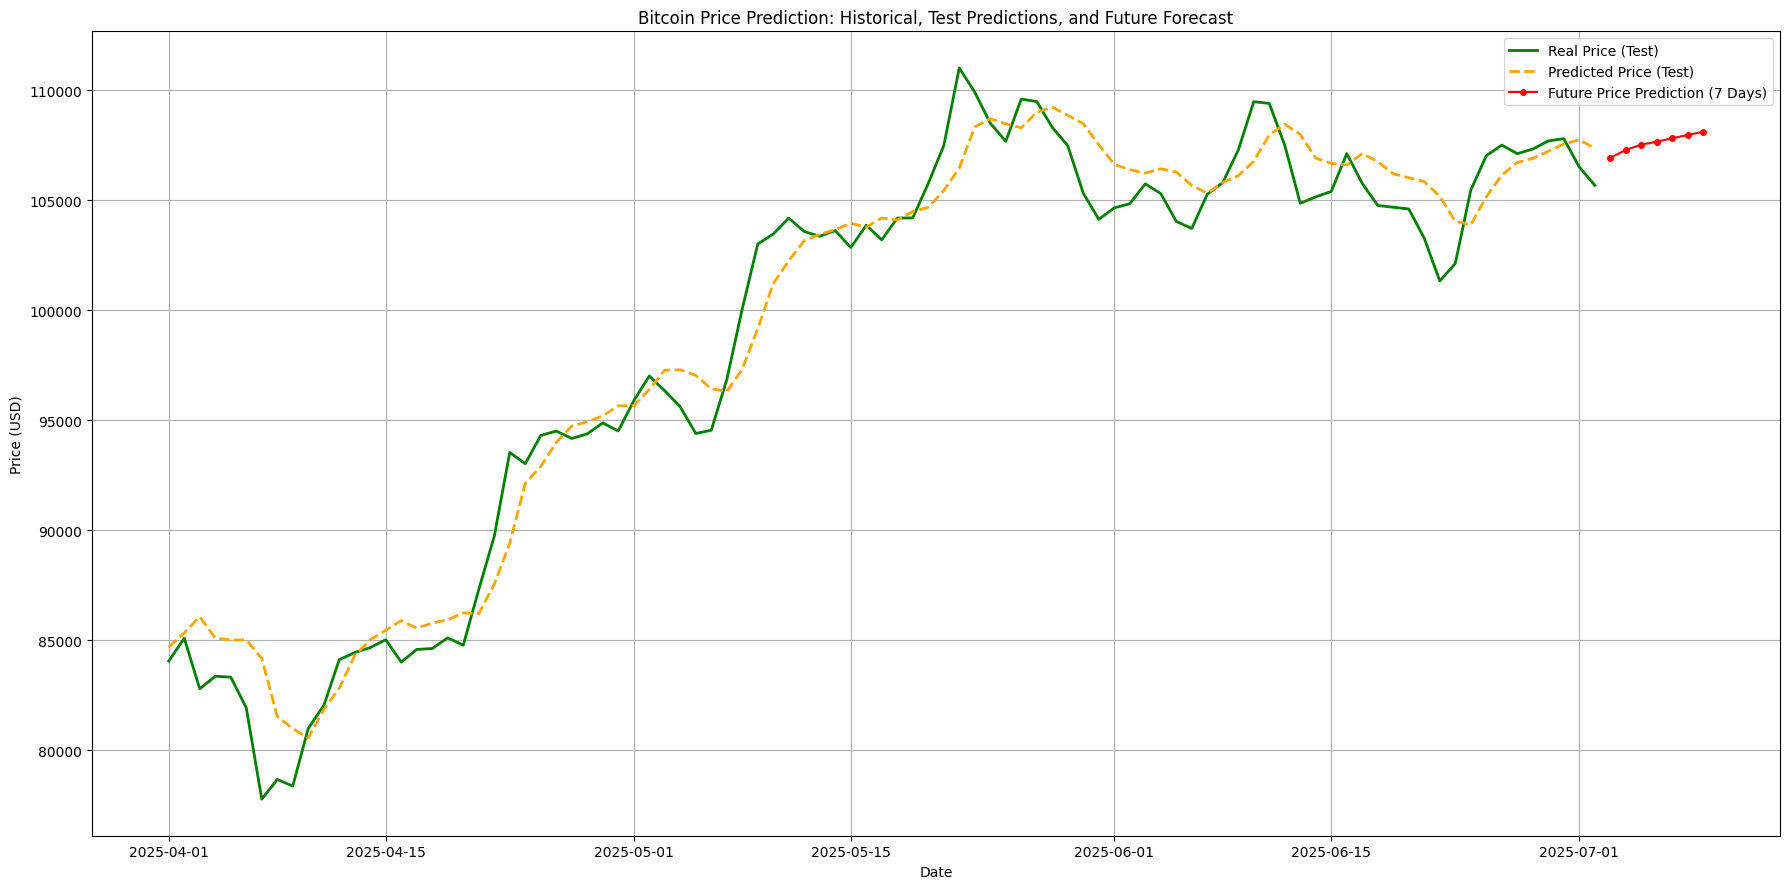

In [ ]:
# График для Price
plt.figure(figsize=(18, 9))

# График реальных цен на тестовом наборе
plt.plot(test['datetime'].iloc[TIME_STEPS:], y_test_price_original, label='Real Price (Test)', color='green', linewidth=2)

# График предсказанных цен на тестовом наборе
plt.plot(test['datetime'].iloc[TIME_STEPS:], predicted_price, label='Predicted Price (Test)', color='orange', linestyle='--', linewidth=2)

# График многошагового прогноза в будущее
last_test_date = test['datetime'].iloc[-1]
future_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=N_STEPS_AHEAD, freq='D')
plt.plot(future_dates, future_prices, label=f'Future Price Prediction ({N_STEPS_AHEAD} Days)', color='red', linestyle='-', marker='o', markersize=4, zorder=5)

plt.title('Bitcoin Price Prediction: Historical, Test Predictions, and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

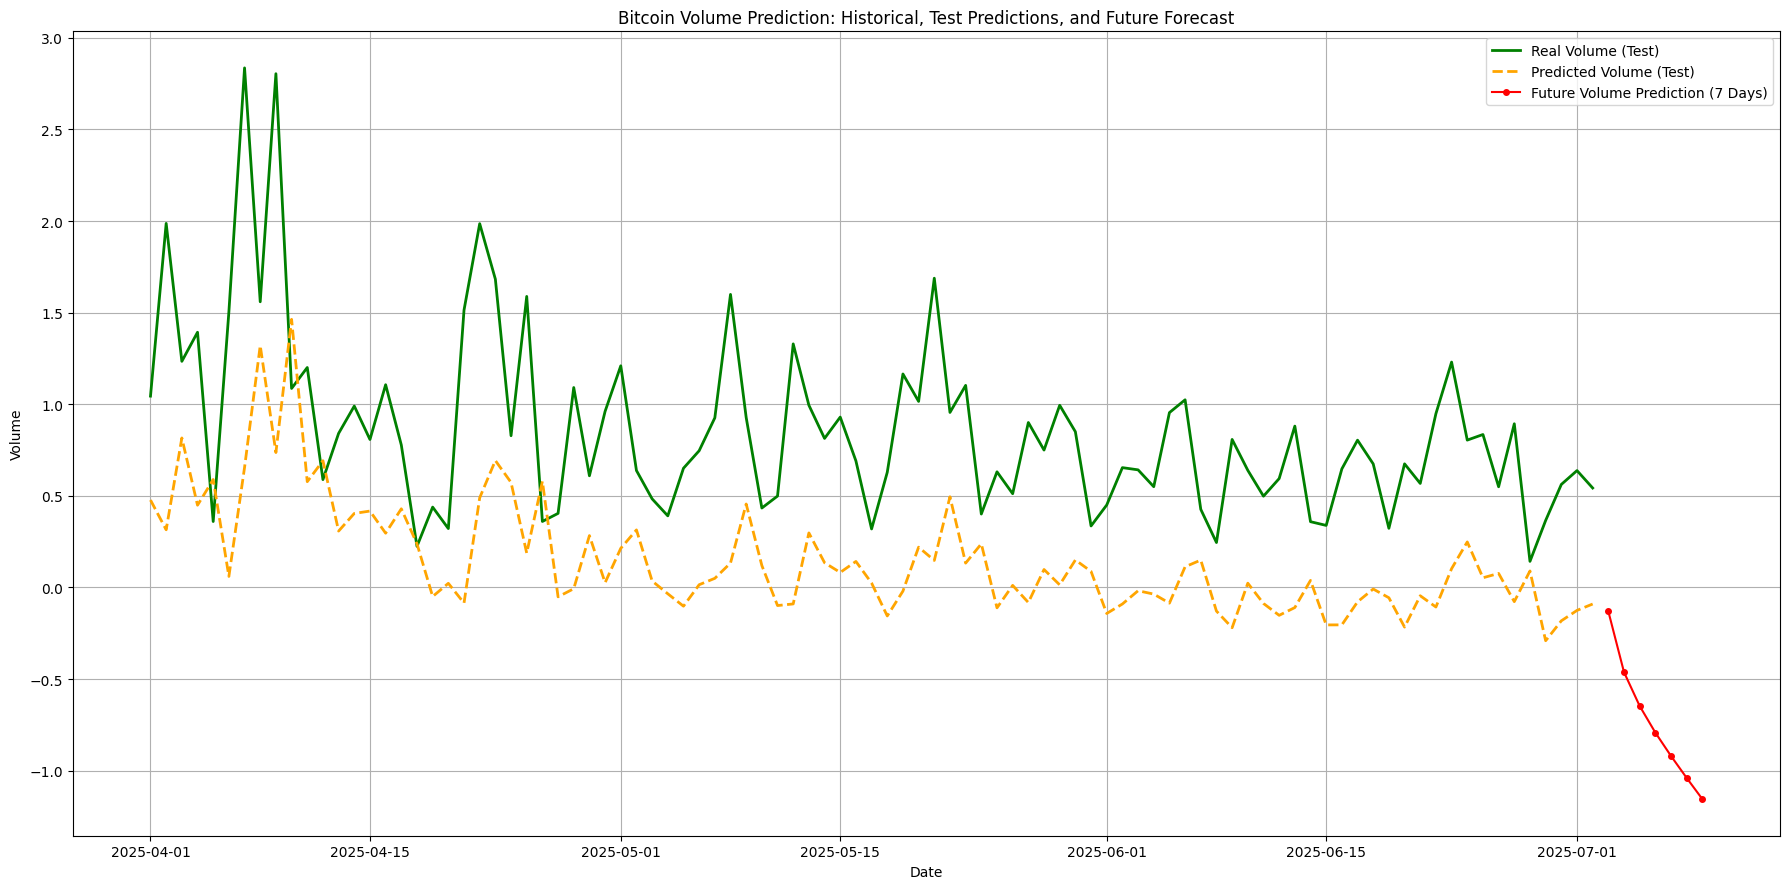

In [ ]:
# График для Volume
plt.figure(figsize=(18, 9))

# График реальных объемов на тестовом наборе
plt.plot(test['datetime'].iloc[TIME_STEPS:], y_test_volume_original, label='Real Volume (Test)', color='green', linewidth=2)

# График предсказанных объемов на тестовом наборе
plt.plot(test['datetime'].iloc[TIME_STEPS:], predicted_volume, label='Predicted Volume (Test)', color='orange', linestyle='--', linewidth=2)

# График многошагового прогноза Volume в будущее
plt.plot(future_dates, future_volumes, label=f'Future Volume Prediction ({N_STEPS_AHEAD} Days)', color='red', linestyle='-', marker='o', markersize=4, zorder=5)

plt.title('Bitcoin Volume Prediction: Historical, Test Predictions, and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Дополнительная оценка (вручную рассчитываем MAPE цены):


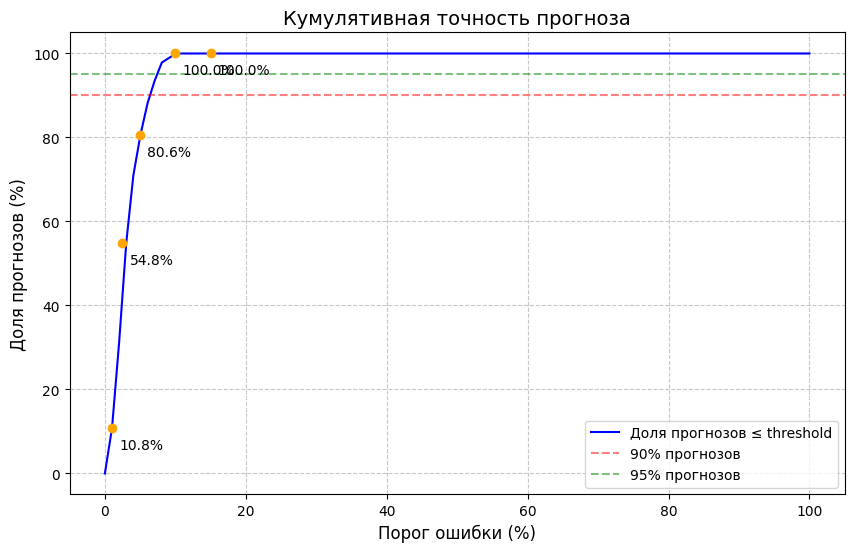

In [ ]:
# Создаем диапазон порогов от 0% до 100%
thresholds = np.linspace(0, 100, 100)  # 100 точек для гладкости

# Считаем долю прогнозов с ошибкой ≤ threshold для каждого порога
accuracies = []
for th in thresholds:
    within_threshold = np.mean(absolute_percentage_errors <= th) * 100
    accuracies.append(within_threshold)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Доля прогнозов ≤ threshold', color='blue')
plt.xlabel('Порог ошибки (%)', fontsize=12)
plt.ylabel('Доля прогнозов (%)', fontsize=12)
plt.title('Кумулятивная точность прогноза', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Добавляем примерные зоны качества
plt.axhline(90, color='red', linestyle='--', alpha=0.5, label='90% прогнозов')
plt.axhline(95, color='green', linestyle='--', alpha=0.5, label='95% прогнозов')

# Аннотации для типичных порогов (например, 5%, 10%, 15%)
for th in [1, 2.5, 5, 10, 15]:
    idx = np.where(thresholds >= th)[0][0]
    plt.scatter(th, accuracies[idx], color='orange', zorder=5)
    plt.text(th + 1, accuracies[idx] - 5, f'{accuracies[idx]:.1f}%', fontsize=10)

plt.legend()
plt.show()